# Project 1: Navigation

This notebook shows the code that was used  to train the RL agent. **Some details about the model**:
1. A fully-connected network with 2 hidden layers of sizes [32, 32] was used to approximate the action value function (Q), with ReLU activations applied to them. The output layer had 4 elements (one per possible action) with softmax activations.
2. Learning rate started at 5e-4 and was multiplicatively decayed by a factor of 0.996 per episode, with a lower bound cap of 1e-6. 3 learning iterations were taken for every learning step (performed every 4 time steps).
3. An epsilon-greedy policy was followed, with epsilon starting at 0.1 and decaying by a multiplicative factor of 0.993 per episode, with a lower bound cap of 0.001.
4. The model was a DQN with the following improvements: Double Q-Learning, Dueling Architecture, Prioritized Experience Replay.
5. Adam optimizer with default parameters was used.
6. Experience replay used batch size 128.

An agent was trained using Deep Q-Learning (DQL) with some modifications listed below. These modifications have been shown in the literature to improve performance, but I have not performed and ablation study to validate the need for each modification. The following modifications were applied:
1. [Double Q-Learning](https://arxiv.org/abs/1509.06461). A second (target) network was used to evaluate the action value of the best action in each state. This helped reduce the overestimation bias inherent to Q-Learning.
2. [Dueling network architecture](https://arxiv.org/abs/1511.06581). Each action value was decomposed into a sum of state value (common for all actions) and an advantage, which has mean of 0 across all possible actions in a state. This allowed me to use the fact that action values in the same state are often strongly correlated because an immediate next action often has less impact on the action value than the state from which the action is taken, thus re-using the updated state value across all actions in the state.
3. [Prioritized experience replay](https://arxiv.org/abs/1511.05952). Instead of uniformaly sampling from all saved experiences, I sampled from experiences which had a larger discrepancy between the target and the current estimate more often. This modification focused model training on more informative experiences and accelerated learning.
4. State consists of multiple frames. My agent supports using multiple previous frames and actions. I experimented with this ieda, but couldn't get it to outperform the baseline, so it's included in the code, but wasn't enabled for the results which I'm presenting.

**Results**:
The average reward of 13.0 per episode (over 100 episodes) was achieved after 467 episodes and the best achieved reward was 15.67 (over 100 episodes) at the end of training (1500 episodes).

**Ideas for future improvement**:
1. Accelerate runtime. It took me around 30 seconds to simulate a single episode even without model training. During execution my CPU load was very light (<10%), so there might be an opportunity to make the code run faster by allowing Unity to make full use of the CPU.
2. Hyperparameter tuning. As is typical in Deep Learning, I found my model to be very sensitive to hyperparameters. Long runtimes prevented me from performing an exhaustive hyperparameter tuning, but it could be done if model runtime is accelerated.
3. Blocking net-zero action loops.The trained agent sometimes showed strange sequences of net-zero actions. For example, turning lert-righ-left-right-... for 10+ time steps. If this can be solved, I believe the agent performance could be improved significantly. If I had more time, I would have investigated these instances in detail by analyzing the Q values based on which the agent was getting stuck in these loops. I'm not sure what could be a solution, but it could be inspired by the results of this analysis. One interesting option could be to include previous actions as part of the state space.

In [1]:
from unityagents import UnityEnvironment
from dqn_agent import Agent
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import namedtuple, deque, OrderedDict
from scipy import signal

import matplotlib.pyplot as plt
%matplotlib inline


plt.ion()

In [3]:
def get_state(state_now, prev_states, prev_actions):
    return np.concatenate((state_now,) + tuple(prev_states) + (np.array(prev_actions),))

def dqn(env, agent, scores, n_episodes=1500, max_t=1000, eps_start=0.1, eps_end=0.001,
        eps_decay=0.993, lr_decay_episode=0.996, min_lr=1e-6):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        lr_decay_episode (float): Learning rate decay multiplier (per episode)
        min_lr (float): Minimum learning rate (capped at the bottom at this value)
    """
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    hundred_episodes_start_time = time.time()
    solved = False
    for i_episode in range(1, n_episodes+1):
        for param_group in agent.optimizer_main.param_groups:
            # adjust learning rate
            param_group['lr'] = max(agent.lr0 * lr_decay_episode**i_episode, min_lr)
        episode_start_time = time.time()
        env_info = env.reset(train_mode=False)[env.brain_names[0]] # reset the environment
        state_now = env_info.vector_observations[0]            # get the current state
        prev_states = deque(maxlen=agent.num_frames)
        prev_actions = deque(maxlen=agent.num_frames)
        score = 0
        for t in range(max_t):
            if len(prev_states) == agent.num_frames:
                state = get_state(state_now, prev_states, prev_actions)
                action = agent.act(state, eps)
                have_enough_frames = True
            else:
                state = None
                # take random actions until have enough frames
                action = np.random.randint(agent.action_size)
                have_enough_frames = False
            env_info = env.step(action)[env.brain_names[0]]        # send the action to the environment
            next_state_now = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            score += reward                                # update the score
            prev_states.append(state_now)
            prev_actions.append(action)
            if have_enough_frames:
                next_state = get_state(next_state_now, prev_states, prev_actions) # note that prev_states and prev_actions are updated at this point to include the current state and action
                agent.step(state, action, reward, next_state, done)
            state_now = next_state_now                             # roll over the state to next time step
            if done:                                       # exit loop if episode finished
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        episode_end_time = time.time()
        print('\rEpisode {}\tAverage Score: {:.2f}, episode took {:.2f} seconds'.format(i_episode, np.mean(scores_window),
              episode_end_time - episode_start_time), end="")
        if i_episode % 100 == 0:
            hundred_episodes_end_time = time.time()
            print('\rEpisode {}\tAverage Score: {:.2f}, 100 episodes took {:.2f} seconds'.format(i_episode,\
                np.mean(scores_window), hundred_episodes_end_time - hundred_episodes_start_time))
            torch.save(agent.QNetwork_main.state_dict(), 'checkpoints/checkpoint_{}.pth'.format(i_episode))
            hundred_episodes_start_time = time.time()
        if (np.mean(scores_window) >= 13.0) & ~solved:
            solved = True
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100,\
                np.mean(scores_window)))
            torch.save(agent.QNetwork_main.state_dict(), 'checkpoints/final_checkpoint.pth')
#             break

env = UnityEnvironment(file_name="Banana.app", no_graphics=False)
env_info = env.reset(train_mode=False)[env.brain_names[0]]
brain = env.brains[env.brain_names[0]]

agent = Agent(state_size=len(env_info.vector_observations[0]),
              action_size=brain.vector_action_space_size,
              seed=0,
              hidden_sizes_list=[32, 32],
              num_frames=0,
              lr0=5e-4,
              gamma=0.99,
              num_iters_learn=3)
scores = []
dqn(env, agent, scores)


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Episode 100	Average Score: 0.67, 100 episodes took 3488.01 seconds
Episode 200	Average Score: 4.30, 100 episodes took 3109.25 seconds
Episode 300	Average Score: 8.10, 100 episodes took 3129.76 seconds
Episode 400	Average Score: 12.37, 100 episodes took 3131.39 seconds
Episode 500	Average Score: 12.44, 100 episodes took 3204.48 seconds
Episode 567	Average Score: 13.03, episode took 32.81 secondsss
Environment solved in 467 episodes!	Average Score: 13.03
Episode 600	Average Score: 13.16, 100 episodes took 7031.28 seconds
Episode 700	Average Score: 14.21, 100 episodes took 17719.78 seconds
Episode 800	Average Score: 14.34, 100 episodes took 5509.97 seconds
Episode 900	Average Score: 15.16, 100 episodes took 3423.15 seconds
Episode 1000	Average Score: 15.34, 100 episodes took 3498.13 seconds
Episode 1100	Average Score: 14.93, 100 episodes took 3544.83 seconds
Episode 1200	Average Score: 15.25, 100 episodes took 3625.00 seconds
Episode 1300	Average Score: 15.43, 100 episodes took 3663.47 se

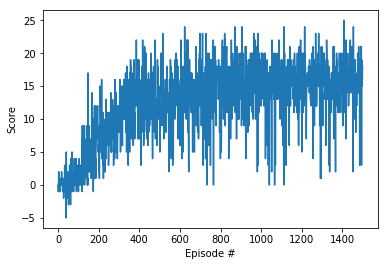

In [4]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

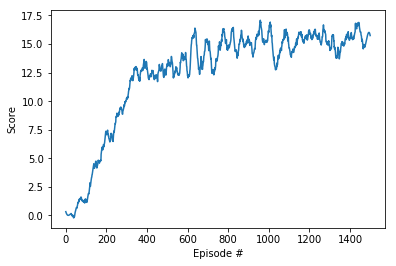

In [5]:
from scipy import signal
plt.plot(np.arange(len(scores)), signal.savgol_filter(scores, 53, 3))
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

# Visualize the trained agent

In [ ]:
# best_model_index = None
# best_score = 0
# for i in range(100, (len(scores) + 1), 100):
#     score = np.mean(scores[i-100:i])
#     if score > best_score:
#         best_score = score
#         best_model_index = i
# print(best_model_index, best_score)
# checkpoint = torch.load('checkpoints/checkpoint_{}.pth'.format(best_model_index))
checkpoint = torch.load('checkpoints/final_checkpoint.pth')
agent.QNetwork_main.load_state_dict(checkpoint)

In [ ]:
# best_model_index = 1300
# checkpoint = torch.load('checkpoint_{}.pth'.format(best_model_index))
# agent.QNetwork_main.load_state_dict(checkpoint)

In [ ]:
# env = UnityEnvironment(file_name="Banana.app")
env_info = env.reset(train_mode=False)[env.brain_names[0]] # reset the environment
state_now = env_info.vector_observations[0]            # get the current state
prev_states = deque(maxlen=agent.num_frames)
prev_actions = deque(maxlen=agent.num_frames)
score = 0
while True:
    if len(prev_states) == agent.num_frames:
        state = get_state(state_now, prev_states, prev_actions)
        action = agent.act(state, eps=0.0)
        have_enough_frames = True
    else:
        state = None
        # take random actions until have enough frames
        action = np.random.randint(agent.action_size)
        have_enough_frames = False
    env_info = env.step(action)[env.brain_names[0]]        # send the action to the environment
    next_state_now = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    prev_states.append(state_now)
    prev_actions.append(action)
    if have_enough_frames:
        next_state = get_state(next_state_now, prev_states, prev_actions) # note that prev_states and prev_actions are updated at this point to include the current state and action
        agent.step(state, action, reward, next_state, done)
    state_now = next_state_now                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break